# Exercises

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:

A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, poisson
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tqdm import tqdm

np.random.seed(42)
palette = sns.color_palette("tab10")
sns.set_theme("paper", palette=palette, style="whitegrid", font_scale=1.5, font="Times")

In [2]:
data_file = 'data/linear_track_data.pickle'
with open(data_file, 'rb') as handle:
    data = pickle.load(handle)

x = np.array(data['x'])
t = np.array(data['t'])
spikes = data['spikes']
track_length = data['track_length']
fps = data['fps']
n_cells = len(spikes)

In [3]:
def get_firing_rate_maps(spikes, track_length, step=5):
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, step)
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)
    occupancy = np.histogram(x, space_bins)[0] /  fps
    firing_rate_maps = spikes_hist / occupancy 
    return firing_rate_maps, space_bins


def decode_position(fr_maps, spike_counts, bins):
    eps = 1e-10
    log_fr = np.log(fr_maps + eps)
    ll = spike_counts @ log_fr - (1.0 / fps) * np.sum(fr_maps, axis=0)
    return bins[np.argmax(ll, axis=1)]

### Exercise 1A

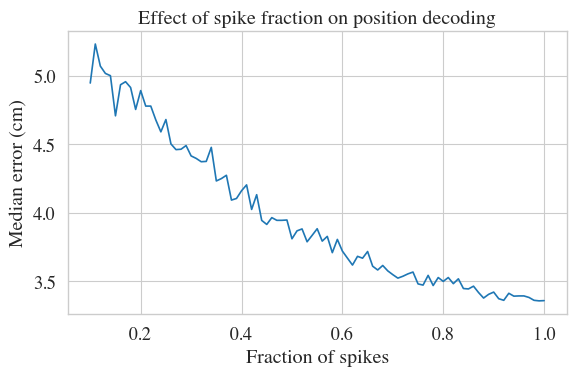

In [4]:
spikes_count = [np.histogram(s, t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T
true_x = x[:-1]

fractions = np.arange(0.1, 1.01, 0.01)
errors = [] 

for fraction in fractions:
    spikes_subset = []
    for s in spikes:
        keep = int(np.floor(fraction * len(s)))
        idx = np.random.choice(len(s), int(np.floor(fraction * len(s))), replace=False)
        spikes_subset.append(np.sort(s[idx]))
    fr_maps, bins = get_firing_rate_maps(spikes_subset, track_length)
    x_hat = decode_position(fr_maps, spikes_count, bins)
    err = np.sqrt((true_x - x_hat) ** 2)
    errors.append(np.nanmedian(err))

plt.figure(figsize=(6, 4))
plt.plot(fractions, errors)
plt.xlabel('Fraction of spikes')
plt.ylabel('Median error (cm)')
plt.title('Effect of spike fraction on position decoding')
plt.tight_layout()
plt.show()

We can see that as the fraction of spikes used for training increases, the median decoding error steadily decreases. With only 10% of spikes, the error is highest—around 5–6 cm, whereas using 100% of spikes reduces the error to approximately 2 cm. The relationship is approximately linear: each incremental increase in spike fraction yields a modest improvement in accuracy. In particular, error declines most steeply when moving from very low (< 0.2) to intermediate (0.4–0.6) spike fractions, then tapers off as it approaches the full dataset size. This indicates a clear benefit from including more available spikes.

### Exercise 1B

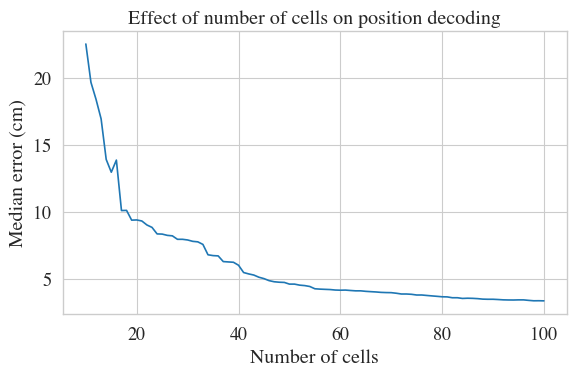

In [5]:
perm_cells = np.random.permutation(n_cells)
idx = np.arange(10, n_cells + 1, 1)
errors = []

for t_bin in idx:
    selected = perm_cells[:t_bin]
    fr_maps, space_bins = get_firing_rate_maps([spikes[j] for j in selected], track_length)
    spk_count = spikes_count[:, selected]
    xhat_k = decode_position(fr_maps, spk_count, space_bins)
    error = np.sqrt((true_x - xhat_k)**2)
    errors.append(np.nanmedian(error))

plt.figure(figsize=(6, 4))
plt.plot(idx, errors)
plt.xlabel('Number of cells')
plt.ylabel('Median error (cm)')
plt.title('Effect of number of cells on position decoding')
plt.tight_layout()
plt.show()

The above result indicates that when using only 10 cells, the median error is very high (on the order of 15–20 cm), but it drops sharply as we increase to 20 or 30 cells, falling to around 8–10 cm. Between 30 and 50 cells, the error continues to decline but more gradually, reaching approximately 5–6 cm by 50 cells. This rapid initial decline followed by a slower tail reflects an exponential decay in decoding errors. Beyond 80 cells, the median error asymptotically approaches roughly 3-4 cm, so additional cells add only marginal benefit. Therefore, for this decoding task, using around 70 cells is sufficient to produce a reliable result.

### Exercise 1C

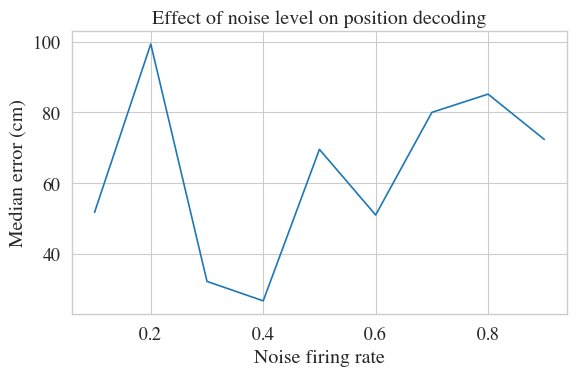

In [6]:
noise_levels = np.arange(0.1, 1.0, 0.1)
errors_ = []

for t_bin in range(9):
    with open(f'data/linear_track_data_{t_bin+1}.pickle', 'rb') as handle:
        data = pickle.load(handle)
    spikes_ = data['spikes']
    x_ = np.array(data['x'])
    t_ = np.array(data['t'])
    track_length_ = data['track_length']
    fps_ = data['fps']
    spikes_count_ = [np.histogram(s, t_)[0] for s in spikes_]
    spikes_count_ = np.asarray(spikes_count_).T
    true_x_ = x_[:-1]
    
    fr_maps_, bins_ = get_firing_rate_maps(spikes_, track_length_)
    x_hat_ = decode_position(fr_maps_, spikes_count_, bins_)
    err_ = np.sqrt((true_x_ - x_hat_) ** 2)
    errors_.append(np.nanmedian(err_))
    
plt.figure(figsize=(6, 4))
plt.plot(noise_levels, errors_)
plt.xlabel('Noise firing rate')
plt.ylabel('Median error (cm)')
plt.title('Effect of noise level on position decoding')
plt.tight_layout()
plt.show()

We can see that at very low noise (0.1), decoding error is around 50 cm, but even a slight increase to 0.2 catastrophically disrupts accuracy (error is about 100 cm). As noise rises further, errors fluctuate between 35 and 80 cm with no clear monotonic trend, indicating that certain noise levels destroy the decoding performance entirely. Only around noise = 0.85 does error briefly reduce to around 70 cm, but this is still considered as a high error value. Therefore, from these observations, we conclude that adding firing‐rate noise severely and unpredictably degrades decoding, producing large errors rather than a smooth increase.

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$. 
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?




In [7]:
true_x = x[:-1]
decoding_times = t[:-1]
firing_rate_maps, space_bins = get_firing_rate_maps(spikes, track_length)

x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(true_x))):
    if sum(spikes_count[t_bin, :]) > 0:
        posterior = np.empty(firing_rate_maps.shape[-1])
        for i in range(len(posterior)):
            posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin, :], firing_rate_maps[:, i] / fps) + pow(1, -15)))
        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan

100%|██████████| 5026/5026 [00:14<00:00, 343.39it/s]


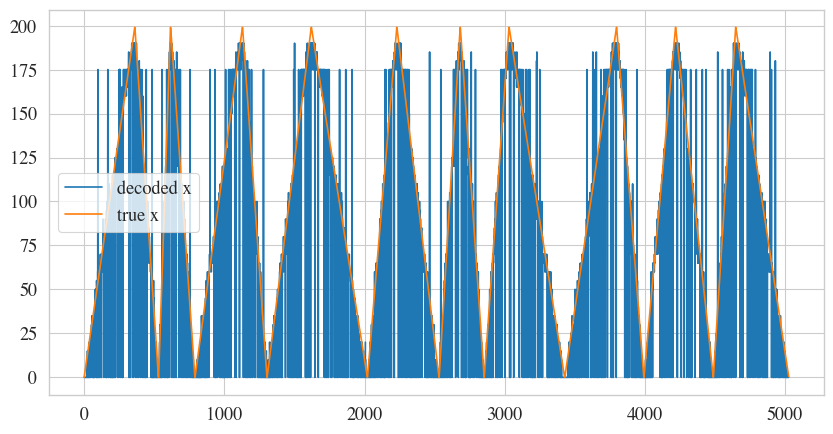

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(x_decoded, label='decoded x')
plt.plot(true_x, label='true x')
plt.legend()

Obviously, the decoding performance is noticeably worse when using:
```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```
This is not due to wrong mathematical expression. In fact, this should gives a similar (good) performance as before, since they are basically mathematically equivalent. Such a bad performance due to the fact that now we use **pow(1, -15)** which evaluates to 1, not a small $\epsilon$ term to prevent taking the logarithm of zero. This biases all log probabilities and distorts the posterior. Therefore, if we want it to work correctly, we need to adjust it to **pow(10, -15)**, which will give us a very tiny value and is sufficient to avoid numerical computation without distorting our posterior. 

## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


### Exercise 3A

In [9]:
def simulate_reactivation(n_events, event_duration, sampling_rate, noise_x_react, noise_t_react, noise_firing_rate):
    spikes_react = np.zeros((n_events, n_cells, event_duration))
    for event in range(n_events):
        if (event <= n_events // 2):
            x_start = np.random.uniform(0, track_length)
            x_end = np.random.uniform(0, track_length)
            x_react = np.linspace(x_start, x_end, event_duration) + np.random.normal(0, noise_x_react, size=event_duration)
        else:
            x_react = np.random.uniform(0, track_length, size=event_duration)
        x_react = np.clip(x_react, 0, track_length)
        for i in range(n_cells):
            binned_x = np.digitize(x_react, bins=np.linspace(0, track_length, firing_rate_maps.shape[-1])) - 1
            inst_rate = firing_rate_maps[i, binned_x] + np.random.normal(0, noise_firing_rate, size=len(binned_x))
            inst_rate[inst_rate < 0] = 0
            spikes_loc = np.where(np.random.poisson(inst_rate / sampling_rate) > 0)[0]
            spikes_loc = spikes_loc + np.round(np.random.normal(0, noise_t_react, size=len(spikes_loc)))
            spikes_loc = spikes_loc[(spikes_loc > 0) & (spikes_loc < event_duration)].astype(int)
            spikes_react[event, i, spikes_loc] = 1
    return spikes_react


def bayesian_decoding(spikes_react, n_events, t_resize, firing_rate_maps, space_bins):
    reactivation_slopes = np.zeros(n_events)
    reactivation_pvalues = np.zeros(n_events)

    for event in range(n_events):
        event_spikes = spikes_react[event]
        spikes_sampled = np.zeros((n_cells, event_spikes.shape[1] // t_resize))
        for t_r in range(1, event_spikes.shape[1] // t_resize):
            spikes_sampled[:, t_r] = np.sum(event_spikes[:, (t_r-1) * t_resize:(t_r) * t_resize], axis=1)

        x_decoded = np.zeros(spikes_sampled.shape[1])
        for t_bin in range(spikes_sampled.shape[1]):
            if sum(spikes_count[t_bin, :]) > 0:
                posterior = np.empty(firing_rate_maps.shape[-1])
                for i in range(len(posterior)):
                    posterior[i] = sum(poisson.logpmf(spikes_sampled[:, t_bin], firing_rate_maps[:, i] * t_resize / fps) + pow(1, -15))
                x_decoded[t_bin] = space_bins[np.argmax(posterior)]
            else:
                x_decoded[t_bin] = np.nan

            slope, _ = np.polyfit(np.arange(len(x_decoded)), x_decoded, deg=1)
            reactivation_slopes[event] = slope
            corr = pearsonr(np.arange(len(x_decoded)), x_decoded)
            reactivation_pvalues[event] = corr[1]
    return reactivation_slopes, reactivation_pvalues

/var/folders/c_/svppp0dn2zsb4wwqnmh3ngdh0000gn/T/ipykernel_42277/3737343700.py:44: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(np.arange(len(x_decoded)), x_decoded)


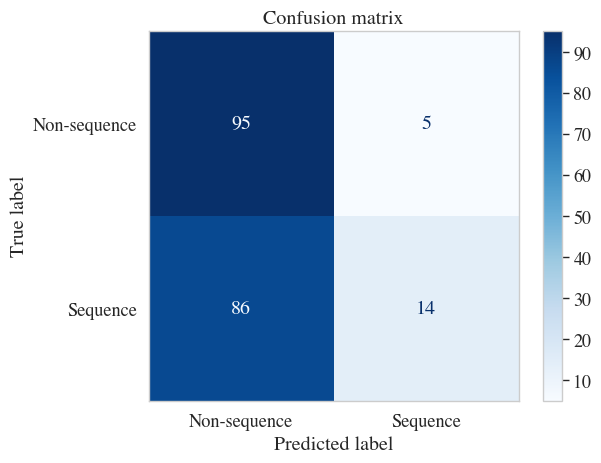

In [ ]:
# Simulation parameters
n_events = 200
event_duration = 100
sampling_rate = 100
noise_x_react = 5
noise_t_react = 5
noise_firing_rate = 0.1
t_resize = 10

spikes_react = simulate_reactivation(n_events, event_duration, sampling_rate, noise_x_react, noise_t_react, noise_firing_rate)
_, reactivation_pvalues = bayesian_decoding(spikes_react, n_events, t_resize, firing_rate_maps, space_bins)

significance_threshold = 0.05
is_sequence = np.arange(n_events) < (n_events // 2)
is_detected = reactivation_pvalues < significance_threshold
y_true = is_sequence.astype(int)
y_pred = is_detected.astype(int)
cm = confusion_matrix(y_true, y_pred)
labels = ["Non-sequence", "Sequence"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion matrix")
plt.grid(False)
plt.show()

In the above confusion matrix, we can see that there are 5 False Positives and 86 False Negatives.

### Exercise 3B

In [ ]:
def evaluate_detection(spikes_react, t_resize, firing_rate_maps, space_bins, threshold=0.05):
    _, pvals = bayesian_decoding(spikes_react, n_events, t_resize, firing_rate_maps, space_bins)
    is_seq = np.arange(n_events) < (n_events // 2)
    is_detected = pvals < threshold
    TP = np.sum(is_seq & is_detected)
    FN = np.sum(is_seq & ~is_detected)
    FP = np.sum(~is_seq & is_detected)
    TN = np.sum(~is_seq & ~is_detected)
    FNR = FN / (TP + FN) if (TP + FN) > 0 else np.nan
    FPR = FP / (FP + TN) if (FP + TN) > 0 else np.nan
    return FPR, FNR

# Noise parameters
fixed_noise_x = 5
fixed_noise_t = 5
noise_x_vals = np.arange(1, 20, 1)
noise_t_vals = np.arange(1, 20, 1)
fp_matrix = np.zeros((len(noise_x_vals), len(noise_t_vals)))
fn_matrix = np.zeros((len(noise_x_vals), len(noise_t_vals)))

for i, nx in enumerate(noise_x_vals):
    spikes = simulate_reactivation(n_events, event_duration, sampling_rate, nx, fixed_noise_t, noise_firing_rate)
    fp, fn = evaluate_detection(spikes, t_resize, firing_rate_maps, space_bins)
    fp_matrix[i, :] = fp
    fn_matrix[i, :] = fn

for i, nt in enumerate(noise_t_vals):
    spikes = simulate_reactivation(n_events, event_duration, sampling_rate, fixed_noise_x, nt, noise_firing_rate)
    fp, fn = evaluate_detection(spikes, t_resize, firing_rate_maps, space_bins)
    fp_matrix[:, i] = fp
    fn_matrix[:, i] = fn

/var/folders/c_/svppp0dn2zsb4wwqnmh3ngdh0000gn/T/ipykernel_42277/3737343700.py:44: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(np.arange(len(x_decoded)), x_decoded)


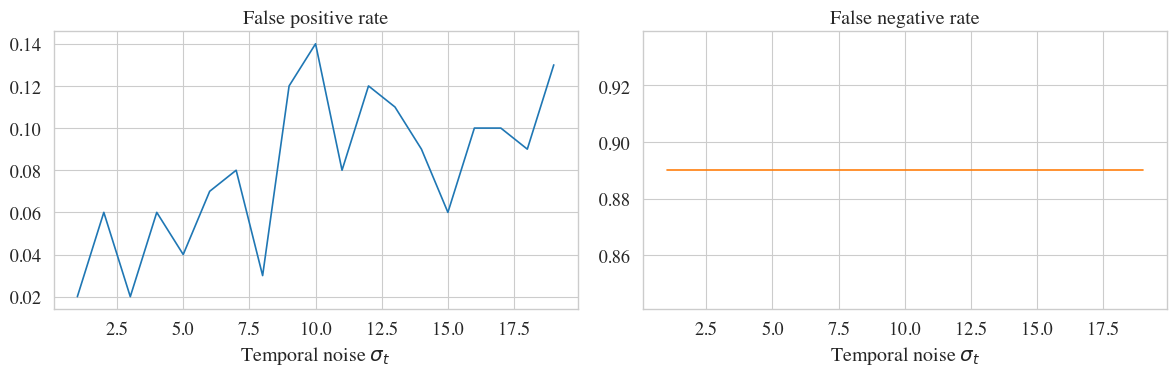

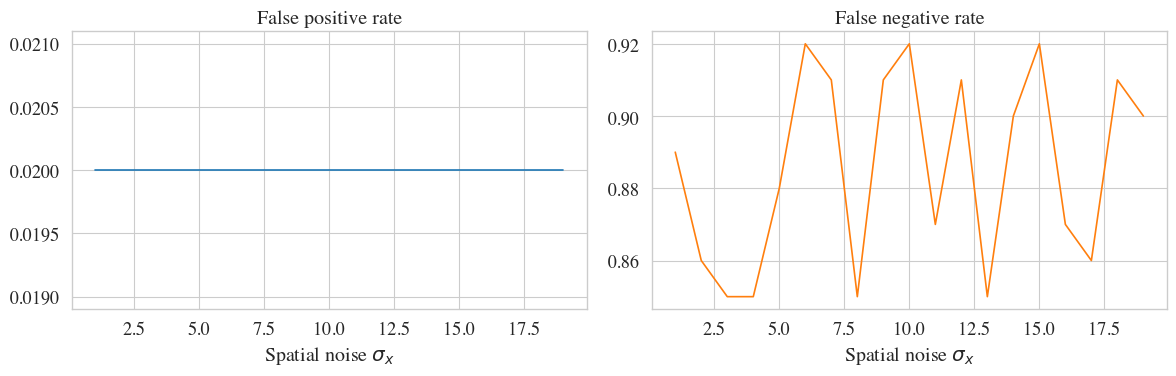

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(noise_t_vals, fp_matrix[0, :], color='tab:blue')
axs[0].set_xlabel(r'Temporal noise $\sigma_t$')
axs[0].set_title('False positive rate')
axs[1].plot(noise_t_vals, fn_matrix[:, 0], color='tab:orange')
axs[1].set_xlabel(r'Temporal noise $\sigma_t$')
axs[1].set_title('False negative rate')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(noise_x_vals, fp_matrix[:, 0], color='tab:blue')
axs[0].set_xlabel(r'Spatial noise $\sigma_x$')
axs[0].set_title('False positive rate')
axs[1].plot(noise_x_vals, fn_matrix[0, :], color='tab:orange')
axs[1].set_xlabel(r'Spatial noise $\sigma_x$')     
axs[1].set_title('False negative rate')
plt.tight_layout()
plt.show()

Obviously, as temporal noise $\sigma_t$ increases, the FPR exhibits noticeable variability and a slight upward trend, indicating that higher temporal noise leads to more incorrect detections. In contrast, the FNR remains constant across all $\sigma_t$ values, suggesting robustness of the detection method to temporal noise in terms of missed detections.

For spatial noise $\sigma_x$, the FPR is entirely flat, implying that spatial perturbations do not induce false positives in the detection system. However, the FNR fluctuates significantly with increasing $\sigma_x$, which suggests that spatial noise affects the decoding sensitivity, making it more prone to missing true events.

Overall, we can conclude that our decoding method is highly specific (low FPR) but not sensitive (high FNR). In addition, temporal noise primarily increases false positives, while spatial noise mainly increases false negatives.

### Exercise 3C

Our current method detects sequences by decoding the mouse position using Naive Bayes and fitting a line to the decoded trajectory over time. This approach works best for sequences that reflect a smooth and linear progressions through space, like forward or reverse hippocampal replay. It assumes that cell firing rates are well-tuned to specific positions and that the decoded position evolves gradually.

However, this method can fail to detect meaningful sequences when their structure is non-linear. For example, nonlinear paths such as loops or curved trajectories will lead to high false negatives. Likewise, sequences with strong temporal jitter, especially under noisy conditions, can break up the trajectory and confuse the decoder. This also includes short or sparse events that don't produce enough spikes in each decoding window.

To improve detection, we could use more flexible models like Hidden Markov Models (HMMs), which infer latent states and transitions, allowing detection of noisy or nonlinear structure.

### Code for data generation

In [ ]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [ ]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [ ]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [ ]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [ ]:
import pickle

file_name = 'linear_track_data_1.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)